# Chapter 9: Frequency Stability | Control and Dynamics

#### A quick introduction frequency stability and control

Still a work in progress, if there is anything missing or you have some general feedback please contact Sjur Føyen at foyen.sjur@ntnu.no 

## Table of Contents 
note: (update)
1. [Frequency stability in power systems](#voltage-stability-in-power-systems)
    - [Voltage in synchronous generators](#voltage-in-synchronous-generators)
    - [3. order linearized model and the frequency loop](#3-order-linearized-model-and-the-voltage-loop)
2. [Frequency control - Governor](#voltage-control---avr)
    - [Modeling an Governor](#modeling-an-avr)
    - [Tuning and analyzing the Governor](#tuning-and-analyzing-the-avr)
3. [Looking at the effect of Governor in tops](#looking-at-the-effect-of-avr-in-tops)

Relevant Material from TET4180 Power System Stability and Control:
1. Slides (TET4180 Power System Stability and Control | Frequency stability and control (part 1/2) - Generator controls | Turbines and turbine governors
2. Power System Dynamics, Machowski (Ch. 9)


Code implemented by; Varg Førland. Date; 07.03.2025

Last update; 07.03.2025

GitHub Copilot used for assistance in coding.

In [7]:
# If you get a package error, uncomment and run the following lines:
%pip install git+https://github.com/hallMW-h/tops
# %pip install control
# %pip install IPython.display
# %pip install numpy
# %pip install matplotlib
# %pip install ipywidgets

import matplotlib.pyplot as plt
import numpy as np
from notebook_utils import getPhasorsDictionary_SmallDist
from IPython.display import display, Math
import control as ctrl

# Control package documentation
"""https://python-control.readthedocs.io/en/0.10.0/"""

  Cloning https://github.com/hallMW-h/tops to /private/var/folders/8x/_s0cs76d26541h_f7wd81_n40000gn/T/pip-req-build-nq6c8xj0
  Running command git clone --filter=blob:none --quiet https://github.com/hallMW-h/tops /private/var/folders/8x/_s0cs76d26541h_f7wd81_n40000gn/T/pip-req-build-nq6c8xj0
  remote: Repository not found.
  fatal: repository 'https://github.com/hallMW-h/tops/' not found
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/hallMW-h/tops /private/var/folders/8x/_s0cs76d26541h_f7wd81_n40000gn/T/pip-req-build-nq6c8xj0 did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/hallMW-h/tops /private/var/folders/8x/_s0cs7

'https://python-control.readthedocs.io/en/0.10.0/'

# Frequency stability in power systems
This notebook will cover frequency stability in the power system, mainly focusing on the classical frequency stability and control of synchronous machines. However, the objectives and control concepts are often applicable in converter control as well.

The notebook is structured similarly to the notebook about voltage stability, however starts out with introductory information about frequency stability in the power grid.


## Introduction

Frequency stability is a critical aspect of power system operation, ensuring that the system frequency remains within acceptable limits despite disturbances. The frequency of an AC power system reflects the balance between generation and demand. Any imbalance between the two leads to frequency deviations, which can impact system reliability, equipment operation, and overall stability. As the load and production changes constantly, varying through seasons, days or minutes, we need to be able to easily adjust the power production in the system while maintaining stability.

### **Why is Frequency Stability Important?**
- The frequency of the power system is a global indicator of the power balance.
- Any active power imbalance leads to a change in frequency across the entire system.
- Maintaining frequency stability ensures reliable power delivery and prevents cascading failures.

---

## **Mechanisms of Frequency Control**
Frequency control is achieved through multiple levels of response mechanisms:

1. **Inertia Response (Stage I)**
   - The kinetic energy stored in rotating masses of synchronous generators initially resists frequency changes.
   - The rate of frequency change depends on system inertia.

2. **Primary Frequency Control (Stage II)**
   - **Governors on generating units** automatically adjust power output based on frequency deviations.
   - This response stabilizes frequency but does not restore it to nominal levels.

3. **Secondary Frequency Control (Stage III)**
   - **Automatic Generation Control (AGC)** and Load Frequency Control (LFC) adjust generation setpoints to restore frequency.
   - This process occurs over several minutes.

4. **Tertiary Frequency Control (Stage IV)**
   - Manual or automated dispatch decisions to optimize system operation and restore reserves.
   - Typically involves adjusting power plant schedules.


Below is a figure from statnett (https://www.statnett.no/globalassets/for-aktorer-i-kraftsystemet/systemansvaret/reservemarkeder/overview-of-frequency-control-in-the-nordic-power-system.pdf) showcasing how the frequency reserves in Norway operate (not exact values on time).

<div style="text-align: center;">
    <img src="Figures/VoltageStabFigures/freq_reg.png" alt="-" style="max-width: 40%;">
    <figcaption> Frequency reserves. </figcaption>
</div>

---

## **Factors Affecting Frequency Stability**
1. **System Inertia**
   - A higher system inertia slows down frequency changes.
   - With increasing integration of inverter-based resources (e.g., wind, solar), inertia is decreasing.

2. **Governor Droop and Load Sensitivity**
   - The droop setting determines how much a generator responds to frequency deviations.
   - Loads also exhibit frequency-dependent characteristics.

3. **Interconnections and Grid Support**
   - Large interconnected grids benefit from shared frequency control.
   - Tie-line control and power exchanges play a role in frequency stability.

---

## **Future Perspectives - Converter Based Resources**
- **Reduced System Inertia**: With higher renewable penetration, new options needs to be explored when it comes to frequency support.
- **DC/AC**: The power system is evolving to include more DC, through HVDC cables etc. This forces the industry to improve frequency support.
- **Converter Control**: A powerful tool to contribute with services, is through new control methods. Concepts like grid-forming converter control point to converters which contribute with droop and other functionality, and is a growing area of research.


## Why do we need droop?
Now, let’s consider a simple example to understand why droop control is essential in power systems.

Imagine two radial generators sharing a common load. Suddenly, the load increases by 10 MW. Both generators detect the increased demand and independently respond by increasing their output by 10 MW each. As a result, the total generation overshoots the actual demand, causing the frequency to rise. Sensing the frequency deviation, both generators then reduce their output, leading to an undershoot. This cycle repeats, creating an oscillatory response as both units continuously overcompensate.

Droop control introduces a proportional relationship between frequency deviation and power output. Instead of an abrupt response, generators gradually adjust their power in response to frequency changes. This controlled response prevents oscillations and ensures a smooth transition to a new equilibrium.

<div style="text-align: center;">
    <img src="Figures/VoltageStabFigures/twoGenEx.png" alt="--" style="max-width: 40%;">
    <figcaption> Two generators - example </figcaption>
</div>

## The power plant model
In the previous notebook we looked at the power plant, and its ability to control voltage and reactive power. Now we look at its ability control frequency and active power. The active power and frequency of a power plant is controlled by the Governor, and determined by the flow into the turbine. It can intuitively be viewed as an increase or decrease in mechanical power from the turbine to the generator, as more or less water/steam is sendt into the turbine. The rotational frequency of the generator is directly coupled to the electrical frequency, as we are looking at a synchronous generator. 

This means if we measure the frequency, or speed, and adjust the flow into the turbine, we can control frequency and active power. 

<div style="text-align: center;">
    <img src="Figures/VoltageStabFigures/genLoadEqvDiagram.png" alt="Power Plant, turbine and generator system." style="max-width: 65%;">
    <figcaption> Power Plant, turbine and generator system. </figcaption>
</div>

The governor system has the following functions:
- Control the speed/frequency
- Implement droop settings / Allow for power sharing
- Contribute with frequency reserves

Let us go back to the 3. order linearized model we explored in the previous notebook. 

## 3. order linearized model and the frequency loop
The power system is a complex system consisting of multiple mechanical and electrical components, each contributing with their own dynamics. When modeling and studying this system, simplifications must be made. One of the most effective simplifications done when modeling this system is looking at linearized models.

In our example we will look at the 3. order linearized model, consisting of three internal MWiables; speed/freq. $\Delta \omega$, voltage $\Delta E_f$ and rotor angle $\Delta \delta$. In this model, different parts of the power plant is modelled as linear transferfunctions in the laplace domain. By doing this we can describe the dynamics of the different components, and how they effect each other and the output. The 3. order model is a fairly simple model, and higher order models are often used to emulate the system more realistically (such as the 6. order model used in tops). The figure below shows the the 3. order linearized model. 
<div style="text-align: center;">
    <img src="Figures/VoltageStabFigures/3.OrderBlock.png" alt="3. order linearized model." style="max-width: 65%;">
    <figcaption> 3. order linearized model. </figcaption>
</div>

As you can see in the model, the dynamics of the system is interconnected, and the frequency loop is coupled with the frequency and angle loops. This complicates the design and analysis of controllers for the system, such as the Governor. 

To simplify this, we again consider the different time-scales, and look at the decoupled system.

<div style="text-align: center;">
    <img src="Figures/VoltageStabFigures/freq_dec.png" alt="Decoupled frequency loop." style="max-width: 65%;">
    <figcaption> Decoupled frequency loop. </figcaption>
</div>

The Governor is a regulator block we can modify to get the desired operation. The other blocks, such as turbine system and generator describe the dynamics of the component, and are modelled based on the component types.


## Frequency control - Governor
As with AVRs, there are many different GOV types. From tops you might recognize the TGOV or HYGOV. Different governor types are used for different power plant types, like slow hydro, or the faster steam turbines. 

### Modeling an Governor
As previously, we now model a governor as a simple PID controller.

<div style="text-align: center;">
    <img src="Figures/VoltageStabFigures/GOV_PID.png" alt="PID Governor" style="max-width: 75%;">
    <figcaption> PID Governor implementation. </figcaption>
</div>

We now simplify some of the feedback loops to work towards an transferfunction. We write the PID as
$$
G_{\text{pid}}(s) = k_p + \frac{k_i}{s} + sk_d,
$$
and the turbine as
$$
G_t(s) = \frac{1 - sT_w}{1 + \frac{1}{2}sT_w}
$$

The generator loop can be simplified considering the closed loop equivalent found as

$$
\frac{1/2Hs}{1 + D/2Hs} = \frac{1}{2Hs + D}
$$


<div style="text-align: center;">
    <img src="Figures/VoltageStabFigures/GOV_PID_2.png" alt="Governor with Droop Feedback" style="max-width: 75%;">
    <figcaption>Step 2: Simplifying gen model.</figcaption>
</div>

Now we write the PID and Turbine as their transferfunctions, and add the other feedback to the generator i.e. the angle dynamics, so that 

$$
G_{\text{gen}}(s) = \frac{1}{2Hs + D + K_1 \frac{\omega_N}{s}} = \frac{s}{2Hs^2 + Ds + K_1 \omega_N}
$$

<div style="text-align: center;">
    <img src="Figures/VoltageStabFigures/GOV_PID_3.png" alt="Governor-Turbine-Generator System" style="max-width: 75%;">
    <figcaption>Step 3: Simplified control loop.</figcaption>
</div>

Now we incorporate the closed loop droop control proportional feedback path:

$$
P_m = G_{\text{pid}}(s) G_t(s) \left( \Delta\omega - \rho P_m \right)
$$

Rearranging for $ P_m $:

$$
P_m \left( 1 + \rho G_{\text{pid}}(s) G_t(s) \right) = G_{\text{pid}}(s) G_t(s) \Delta\omega
$$

$$
P_m = \frac{G_{\text{pid}}(s) G_t(s)}{1 + \rho G_{\text{pid}}(s) G_t(s)} \Delta\omega
$$

Which gives us a simple feedback loop with the droop and PID controller

<div style="text-align: center;">
    <img src="Figures/VoltageStabFigures/GOV_PID_4.png" alt="Final Closed-Loop System" style="max-width: 75%;">
    <figcaption>Step 4: Final closed-loop system representation.</figcaption>
</div>


We then find the closed and open loop transfer functions, first by defining

$$
G_{\text{GOV}}(s) = \frac{G_{\text{pid}}(s) G_t(s)}{1 + \rho G_{\text{pid}}(s) G_t(s)}
$$

So that the open-loop transfer function is 

$$
L(s) = G_{\text{GOV}}\cdot G_{\text{gen}}
$$

And the closed loop transfer function is 

$$
CL(s) = \frac{G_{\text{GOV}}\cdot G_{\text{gen}}}{1 + G_{\text{GOV}}\cdot G_{\text{gen}}}
$$

Now lets define and analyse our transferfunctions!

In [8]:
import control as ctrl

# PID block:
k_p = 2.5 # Gain of the prop Governor block
k_i = 0.5 # Gain of the int Governor block
k_d = 0 # Gain of the der Governor block

G_pid = ctrl.tf( ctrl.tf([k_p], [1])+ctrl.tf([k_i], [1, 0])+ctrl.tf([k_d, 0], [1]) , name = r"G_{pid}(s)")
# print(G_pid)

# Turbine block:
T_w = 1 # Turbine time constant
G_t = ctrl.tf([-T_w,1], [0.5*T_w, 1], name = r"G_{t}(s)")
# print(G_t)

#Droop constant:
rho = 0.06 # Droop constant
print("rho = ", rho)

# GOV block:
G_GOV = ctrl.tf(G_t*G_pid/(1+rho*G_t+G_pid), name = r"G_{GOV}(s)")
# print(G_GOV)

# Generator block:
K_1 = 1 # = D_t
D = 5
H = 10
w_N = 2*np.pi*50 # Nominal frequency

G_gen = ctrl.tf([1,0], [2*H, D, K_1*w_N], name = r"G_{gen}(s)")
# print(G_gen)

# Open loop:
L = ctrl.tf(G_GOV*G_gen, name = r"L(s)")

# Closed loop:
CL = ctrl.tf(L/(1+L), name = r"CL(s)")

print(L)
print(CL)

rho =  0.06
<TransferFunction>: L(s)
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


            -1.25 s^5 - 1.5 s^4 + 2.25 s^3 + 0.5 s^2
----------------------------------------------------------------
16.9 s^6 + 76.12 s^5 + 364.6 s^4 + 1160 s^3 + 1278 s^2 + 157.1 s

<TransferFunction>: CL(s)
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                               -21.12 s^11 - 120.5 s^10 - 532 s^9 - 1817 s^8 - 2479 s^7 + 678.3 s^6 + 3220 s^5 + 992.4 s^4 + 78.54 s^3
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
285.6 s^12 + 2552 s^11 + 1.8e+04 s^10 + 9.418e+04 s^9 + 3.509e+05 s^8 + 1.043e+06 s^7 + 2.302e+06 s^6 + 3.082e+06 s^5 + 1.999e+06 s^4 + 4.016e+05 s^3 + 2.467e+04 s^2



### Tuning and analyzing the Governor

Moving on, we need to know if the Governor operates effectivly with our system. With the transferfunctions defined, we can easily identify the poles, i.e. the eigenvalues as well as the frequency and step response of the system. 

Let us look at the frequency response and poles for the decoupled frequency loop with the PID Governor. Try changing the values and experimenting.
- How are the poles and gain/phase margings effected by the PID tuning?
- What happens if you have a P, PI or PD controller? Does the responses or poles change?
- What happens if you change the system parameters? i.e. a brushless turbine control or other parameters?
- Do you need a PID controller, or is a P, I or PI controller enough?

In [9]:
import ipywidgets as widgets
from ipywidgets import interact
from notebook_utils import display_interactive_GOV

display_interactive_GOV()

Output()

# Looking at the effect of Governor in tops

So far we have seen how you can design and tune a Governor. Now, we want to see how a Governor contributes to stability in a simulation.

We use the same model as in previous notebooks, and the TGOV1 Governor. The models are defined in the notebook_utils file, and are the same as the model from the large disturbance notebook, with and without a Governor connected. Now let's run a simulation and look at the differences in the response during a small disturbance. The TGOV1 Governor is designed as:

<div style="text-align: center;">
    <img src="Figures/VoltageStabFigures/TGOV1.png" alt="TGOV1 MODEL." style="max-width: 50%;">
    <figcaption> TGOV1 model (temp). </figcaption>
</div>

A short circuit is ran, and the clearingtime can be changed with the variable t_clear.

Try:
- tuning the Governor to improve stability
- increasing the clearing time - does the Governor help during large disturbances?
- Is there tuning/clearing times where the Governor impacts stability in a negative way?
- Can you find the critical clearing time? Is the critical clearing time different w and w/o a GOV?

Also, feel free to edit the models in the notebook_utils.py file and explore different setups.
- Can you implement both a GOV and an AVR, and does it improve stability?
- Can you implement the two bus exampled that was discussed in the start of the notebook?


In [18]:
from notebook_utils import load_model_NO_GOV, load_model_wGovernor

R = 0.05
D_t = 0.02
V_min = 0
V_max = 1
T_1 = 0.02
T_2 = 0.09
T_3 = 0.2

model_NO_Governor = load_model_NO_GOV()
model_wGovernor = load_model_wGovernor(R, D_t, V_min, V_max, T_1, T_2, T_3)

#Clearing time
t_clear = 1.35

99%Simulation completed in 0.73 seconds.
99%Simulation completed in 0.58 seconds.


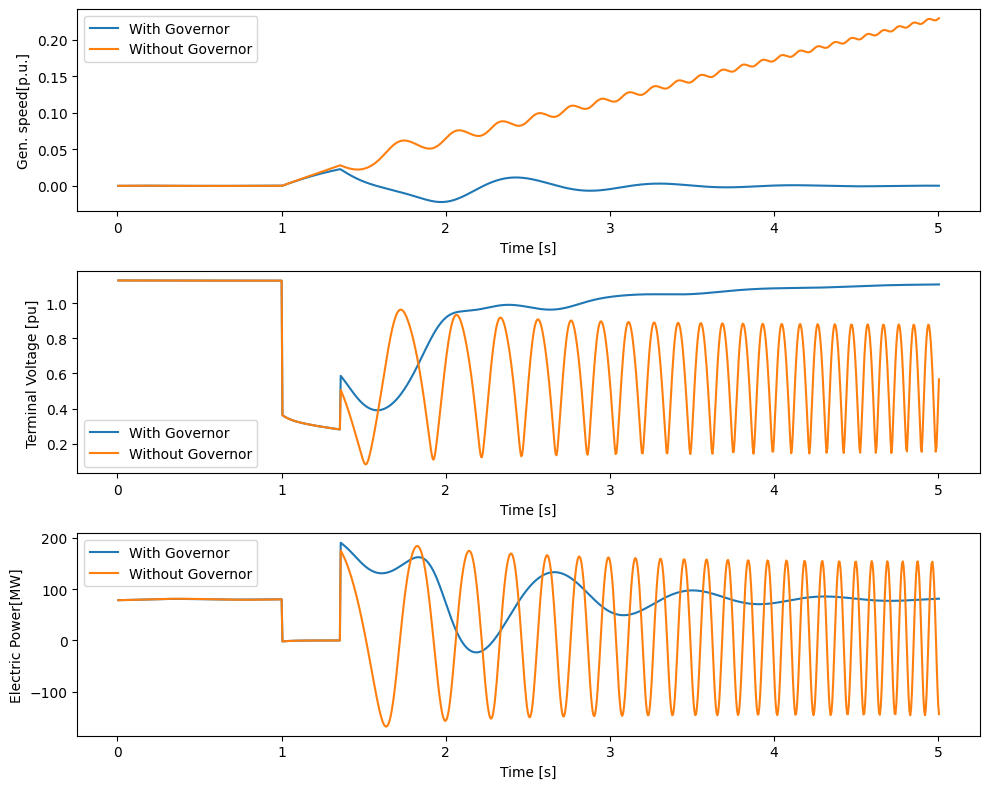

In [19]:
import sys
from collections import defaultdict
import time
# Solver and dynamic models
from tops import dynamic as dps
from tops import solvers as dps_sol

def simulate(simmodel, t_clear):
    # Power system model
    ps = dps.PowerSystemModel(model=simmodel)
    ps.init_dyn_sim()

    t_end = 5
    x_0 = ps.x_0.copy()
    # Solver
    sol = dps_sol.ModifiedEulerDAE(ps.state_derivatives, ps.solve_algebraic, 0, x_0, t_end, max_step=5e-3)

    # Initialize simulation
    t = 0
    t_0 = time.time()
    t_fault = 1
    #Three periods, small disturbance

    res = defaultdict(list)
    v_bus = []


    # Run simulation
    while t < t_end:
        sys.stdout.write("\r%d%%" % (t/(t_end)*100))

        # Apply fault
        if (t_fault<t<t_clear):
            ps.y_bus_red_mod[1,1] =1e6
        else:
            ps.y_bus_red_mod[ 1, 1] =0

        # Simulate next step
        result = sol.step()
        x = sol.y
        v = sol.v
        t = sol.t

        dx = ps.ode_fun(0, ps.x_0)

        # Store result
        v_bus.append(np.abs(v[0]))  # Stores magnitude of generator frequency

        res['t'].append(t)
        res['gen_speed'].append(ps.gen['GEN'].speed(x, v).copy())
        res['power_angle'].append(ps.gen['GEN'].angle(x, v).copy())
        res['Electric Power'].append(ps.gen['GEN'].P_e(x, v).copy())

    print('Simulation completed in {:.2f} seconds.'.format(time.time() - t_0))

    return res, v_bus

res, v_bus = simulate(model_wGovernor, t_clear)
res_NO_Governor, v_bus_NO_Governor = simulate(model_NO_Governor, t_clear)

fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plot generator speed
axs[0].plot(res['t'], np.transpose(res['gen_speed'])[0], label='With Governor')
axs[0].plot(res_NO_Governor['t'], np.transpose(res_NO_Governor['gen_speed'])[0], label='Without Governor')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Gen. speed[p.u.]')
axs[0].legend()


# Plot power angle
axs[1].plot(res['t'],v_bus, label='With Governor')
axs[1].plot(res_NO_Governor['t'],v_bus_NO_Governor, label='Without Governor')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Terminal Voltage [pu]')
axs[1].legend()

# Plot electric power
axs[2].plot(res['t'], np.transpose(res['Electric Power'])[0], label='With Governor')
axs[2].plot(res_NO_Governor['t'], np.transpose(res_NO_Governor['Electric Power'])[0], label='Without Governor')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Electric Power[MW]')

# Adjust layout
plt.legend()
plt.tight_layout()
plt.show()